In [13]:
import numpy as np
from imageio import imread, imwrite
from scipy.ndimage.filters import convolve
import matplotlib.pyplot as plt

from skimage import filters, color
#from skimage import io, transform, util

from pyCAIR import cropByColumn

In [47]:
def displayims(a,b,a_title, b_title):
    fig = plt.figure(figsize=(15,15))
    plt.subplot(121),plt.imshow(a)
    plt.title(a_title), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(b)
    plt.title(b_title), plt.xticks([]), plt.yticks([])
    plt.show()

In [15]:
'''def seam_carve(img, f, n):
    for i in range(n):
        eimg = f(img)
        img = transform.seam_carve(img, eimg, 'vertical', 1)
    displayims(img, eimg, "img", "eimg")
    return img, eimg'''

'def seam_carve(img, f, n):\n    for i in range(n):\n        eimg = f(img)\n        img = transform.seam_carve(img, eimg, \'vertical\', 1)\n    displayims(img, eimg, "img", "eimg")\n    return img, eimg'

In [16]:
'''img, eimg = seam_carve(img, calc_energy, 10)
displayims(img, eimg, "original image", "new image?")'''

'img, eimg = seam_carve(img, calc_energy, 10)\ndisplayims(img, eimg, "original image", "new image?")'

# Backward Energy

In [117]:
def calc_energy(img):
    #img = img.astype('float')
    energy_map = filters.sobel(color.rgb2gray(img))
    return energy_map

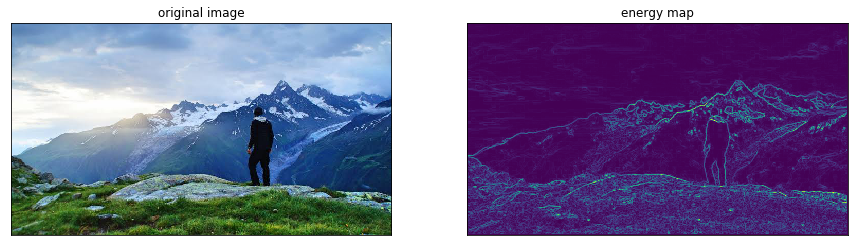

In [111]:
img = imread('images2.jpeg')
energy_map = calc_energy(img)
displayims(img, energy_map, "original image", "energy map")

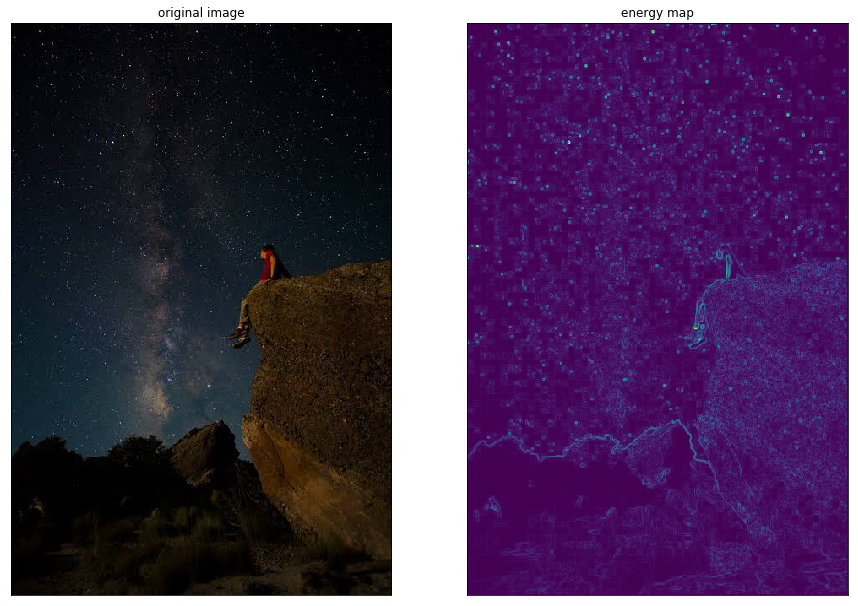

In [89]:
img2 = imread('images4.jpeg')
energy_map = calc_energy(img2)
displayims(img2, energy_map, "original image", "energy map")

In [54]:
def min_seam(img, func):
    r, c, _ = img.shape
    if func == "backward":
        energy_map = calc_energy(img)
    else:
        energy_map = forward_energy(img)
    
    M = energy_map.copy()
    backtrack = np.zeros_like(M, dtype=np.int)
    
    for i in range(1, r):
        for j in range(0, c):
            # Handle the left edge of the image, to ensure we don't index -1
            if j == 0:
                idx = np.argmin(M[i - 1, j:j + 2])
                backtrack[i, j] = idx + j
                min_energy = M[i - 1, idx + j]
            else:
                idx = np.argmin(M[i - 1, j - 1:j + 2])
                backtrack[i, j] = idx + j - 1
                min_energy = M[i - 1, idx + j - 1]

            M[i, j] += min_energy

    return M, backtrack

In [110]:
def carve_column(img, func):
    r, c, ch = img.shape
    M, backtrack = min_seam(img, func)

    # Create a (r, c) matrix filled with the value True
    # We'll be removing all pixels from the image which
    # have False later
    mask = np.ones((r, c), dtype=np.bool)

    # Find the position of the smallest element in the
    # last row of M
    j = np.argmin(M[-1])

    for i in reversed(range(r)):
        # Mark the pixels for deletion
        mask[i, j] = False
        j = backtrack[i, j]

    # Since the image has 3 channels, we convert our
    # mask to 3D
    #print (mask)
    mask = np.stack([mask] * ch, axis=2)
    
    
    # Delete all the pixels marked False in the mask,
    # and resize it to the new image dimensions
    new = img[mask].reshape((r, c-1, ch))

    return new

In [60]:
def crop_c(img, scale, func, flag=True):
    if flag:
        val = scale
    else:
        r, c, _ = img.shape
        new = int(scale * c)
        val = new
        
    for i in range(val):
        img = carve_column(img, func)
    return img
    

In [102]:
def crop_r (img, scale, func, flag=True):
    img = np.rot90(img, 1, (0,1)) 
    img = crop_c(img, scale, func, flag)
    img = np.rot90(img, 3, (0,1))
    return img

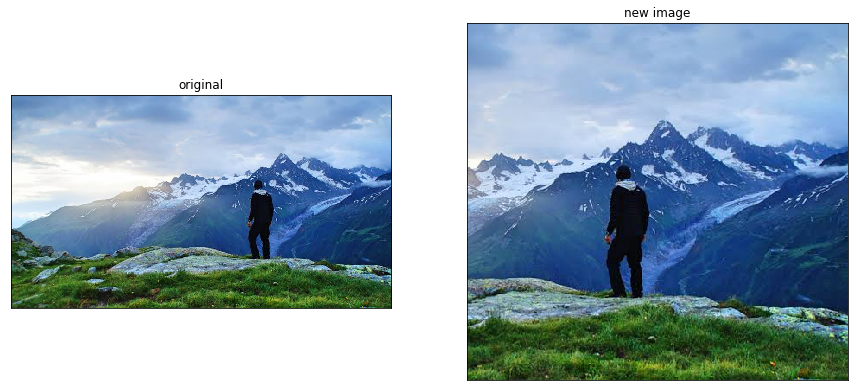

In [61]:
new = crop_c(img, 300, "backward")
displayims(img, new, "original", "new image")

In [113]:
new = crop_c(img, 200, "backward")
displayims(img, new, "original", "backward seam-carving image")

KeyboardInterrupt: 

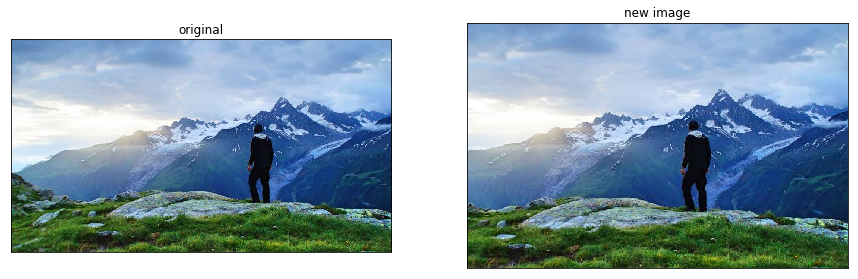

In [63]:
new = crop_c(img, 100, "backward")
displayims(img, new, "original", "new image")

In [108]:
new = crop_r(img2, 200, "backward")
displayims(img2, new, "original", "new image (horizontal)")

KeyboardInterrupt: 

# Forward Energy

In [37]:
def forward_energy(img):
    height = img.shape[0]
    width = img.shape[1]
    
    I = color.rgb2gray(img)
    energy = np.zeros((height, width))
    m = np.zeros((height, width))
    
    for i in range(1, height):
        for j in range(width):
            up = (i-1) % height
            down = (i+1) % height
            left = (j-1) % width
            right = (j+1) % width
    
            mU = m[up,j]
            mL = m[up,left]
            mR = m[up,right]
                
            cU = np.abs(I[i,right] - I[i,left])
            cL = np.abs(I[up,j] - I[i,left]) + cU
            cR = np.abs(I[up,j] - I[i,right]) + cU
            
            cULR = np.array([cU, cL, cR])
            mULR = np.array([mU, mL, mR]) + cULR
            
            argmin = np.argmin(mULR)
            m[i,j] = mULR[argmin]
            energy[i,j] = cULR[argmin]
            
    return energy

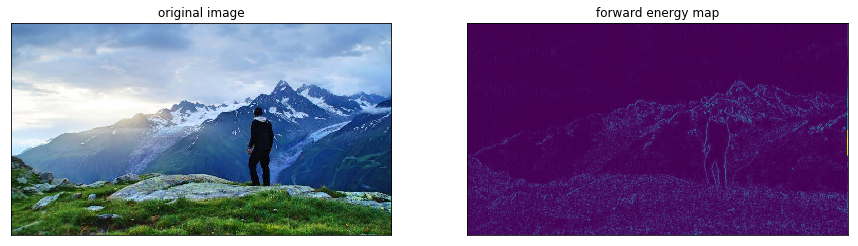

In [49]:
new = forward_energy(img)
displayims(img, new, "original image", "forward energy map")

In [ ]:
new = crop_c(img, 300, "forward")
displayims(img, new, "original", "foward seam-carving image")

In [ ]:
new = crop_c(img, 200, "forward")
displayims(img, new, "original", "foward seam-carving image")

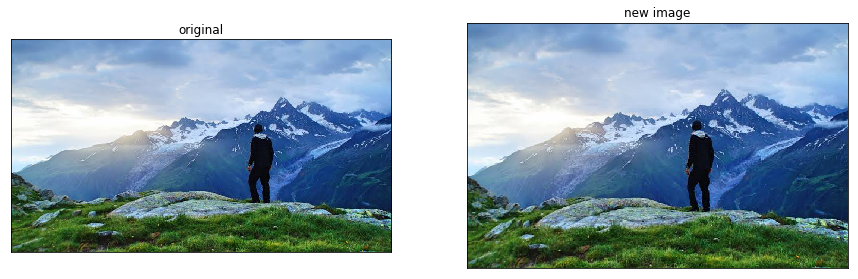

In [66]:
new = crop_c(img, 100, "forward")
displayims(img, new, "original", "new image")

In [ ]:
new = crop_r(img2, 200, "forward")
displayims(img2, new, "original", "new image (horizontal)")

# Proposed Algorithm

72.63982884156556


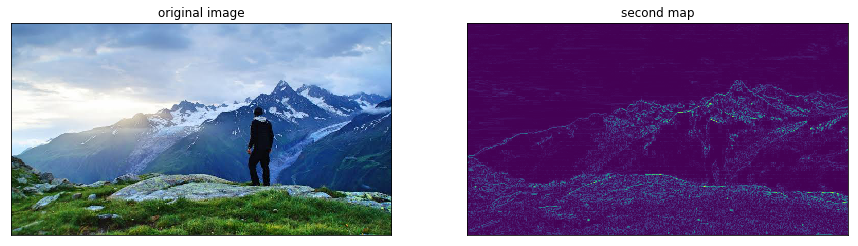

In [93]:
def second_map(img):
    f = np.array([
        [0, 0, 0],
        [0, -1, 0],
        [0, 1, 0]
    ])
    f = np.stack([f] * 3, axis = 2)
    img = img.astype('float32')
    convolved = np.absolute(convolve(img, f))
    energy_map = convolved.sum(axis=2)
    return energy_map

energy_map = second_map(img)
displayims(img, energy_map, "original image", "second map")

In [100]:
def new_carve_column(img, func, value):
    r, c, ch = img.shape
    M, backtrack = min_seam(img, func)

    # Create a (r, c) matrix filled with the value True
    # We'll be removing all pixels from the image which
    # have False later
    mask = np.ones((r, c), dtype=np.bool)

    # Find the position of the smallest element in the
    # last row of M
    j = np.argmin(M[-1])

    for i in reversed(range(r)):
        # Mark the pixels for deletion
        if M[i,j] > value:
            return "FAKE NEWS"
        mask[i, j] = False
        j = backtrack[i, j]

    # Since the image has 3 channels, we convert our
    # mask to 3D
    #print (mask)
    mask = np.stack([mask] * ch, axis=2)
    
    
    # Delete all the pixels marked False in the mask,
    # and resize it to the new image dimensions
    new = img[mask].reshape((r, c-1, ch))

    return new

In [99]:
def new_crop_c(img, scale, func, alpha, flag=True):
    value = np.std(img) * alpha
    if flag:
        val = scale
    else:
        r, c, _ = img.shape
        new = int(scale * c)
        val = new
        
    num = 0
    while 1:
        img2 = new_carve_column(img, func, value)
        if img2 != "FAKE NEWS":
            num+=1
            img = img2
        if num == val -1:
            break
    return img
    

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  del sys.path[0]


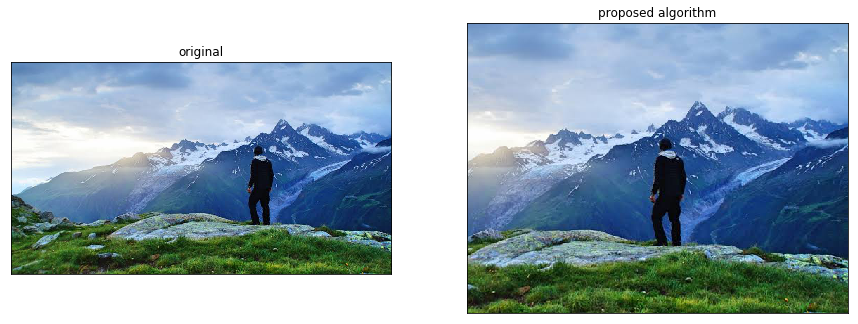

In [105]:
new = new_crop_c(img, 200, "backward", 2)
displayims(img, new, "original", "proposed algorithm")

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  del sys.path[0]


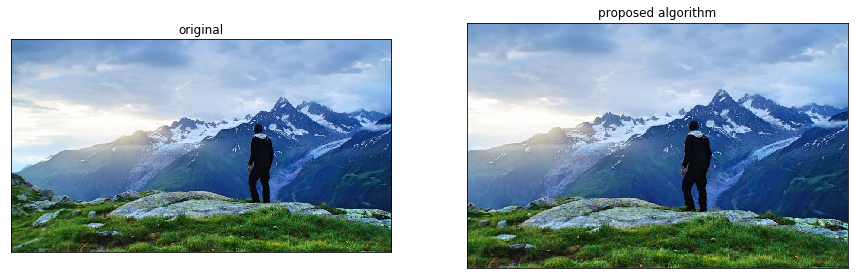

In [112]:
new = new_crop_c(img, 100, "backward", 2)
displayims(img, new, "original", "proposed algorithm")

# Trying Different Pictures

In [122]:
image = imread('mansunset.jpeg')
print (image.shape)

(300, 590, 3)


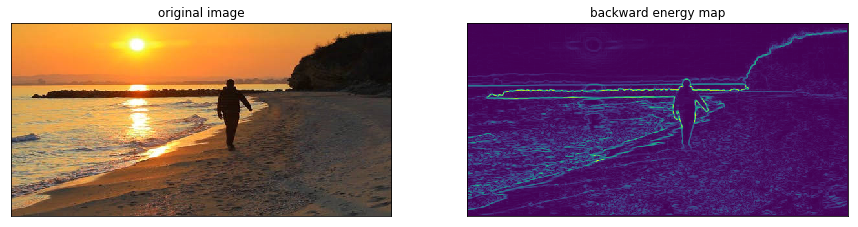

In [115]:
energy_map = calc_energy(image)
displayims(image, energy_map, "original image", "backward energy map")

In [123]:
new = crop_c(image, 50, "backward")
displayims(image, new, "original", "backward seam-carving image")

ValueError: The parameter `image` cannot be an empty array

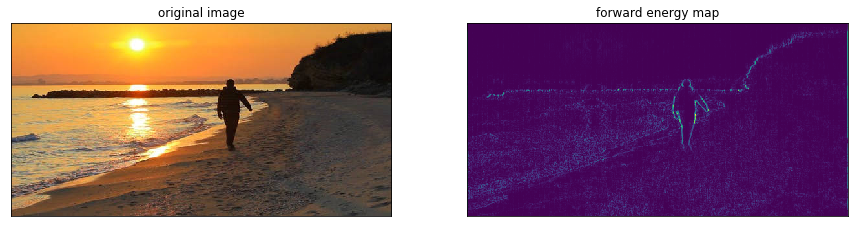

In [118]:
new = forward_energy(image)
displayims(image, new, "original image", "forward energy map")

In [ ]:
new = crop_c(image, 50, "forward")
displayims(image, new, "original", "forward seam-carving image")

In [ ]:
new = new_crop_c(image, 50, "backward", 2)
displayims(image, new, "original", "proposed algorithm")